# Case Study 4.1 - Recommendation Systems

First we will import the necessary modules. Make sure to download graphlab from https://turi.com/ and make sure to register for a license. You can also download it from the command prompt on Mac or Linux using 'sudo pip install graphlab-create'. You will also need to install scikit-learn, pandas, matplotlib, and numpy.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import graphlab as gl

gl.canvas.set_target('ipynb')
gl.set_runtime_config("GRAPHLAB_CACHE_FILE_LOCATIONS", "Log") 

This non-commercial license of GraphLab Create for academic use is assigned to mawhybe@gmail.com and will expire on November 24, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1511866358.log


## Getting the Data
For this tutorial, we use the dataset(s) provided by [MovieLens](http://grouplens.org/datasets/movielens). MovieLens has several datasets. For this tutorial, we will use the [100K dataset](http://grouplens.org/datasets/movielens/100k/). This dataset set consists of:
- 100,000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.
- Simple demographic info for the users (age, gender, occupation, zip)

Download the [u.data](http://files.grouplens.org/datasets/movielens/ml-100k/) file. It has the following tab-separated format: **user id | item id | rating | timestamp**. The timestamps are in Unix seconds since 1/1/1970 UTC is [EPOCH format](http://www.unixtimestamp.com/index.php).

## Working with the Dataset 

We will first load the dataset into GraphLab SFrame and inspect the data. Make sure you have the data downloaded and that the 'ml-100k' folder is in the same directory as this notebook.

In [2]:
sframe = gl.SFrame.read_csv('ml-100k/u.data', header=False, delimiter='\t')
sframe.rename({'X1':'user_id', 'X2':'item_id', 'X3':'rating', 'X4':'timestamp'})
sframe

Finished parsing file /home/user/Module4/Recommending_Movies/ml-100k/u.data

Parsing completed. Parsed 100 lines in 0.267281 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/user/Module4/Recommending_Movies/ml-100k/u.data

Parsing completed. Parsed 100000 lines in 0.178979 secs.

user_id,item_id,rating,timestamp
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596
298,474,4,884182806
115,265,2,881171488
253,465,5,891628467
305,451,3,886324817
6,86,3,883603013


In [3]:
gl.canvas.set_target('ipynb')
sframe.show()

In [4]:
sframe['rating'].sketch_summary()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |     100000    |   Yes    |
|        Min         |      1.0      |   Yes    |
|        Max         |      5.0      |   Yes    |
|        Mean        |    3.52986    |   Yes    |
|        Sum         |    352986.0   |   Yes    |
|      Variance      |  1.2671283804 |   Yes    |
| Standard Deviation | 1.12566797076 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |       5       |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+-------+-------+-------+-------+------+
| value |   4   |   3   |   5   |   2   |  1   |
+-------+-------+-------+-------+-------+------+
| count | 34174 | 27145 | 21201 | 11370 | 6110 |
+-------+-------+-------+-------+-------+------+

Quantiles: 
+-----+-----+-----+-----+-----+-----+-----+-----+------+
|  0% |  1% 

In [5]:
sframe['rating'].show()

## Calculating Sparsity

The dataset sparsity can be calculated as:
$$ 𝑆𝑝𝑎𝑟𝑠𝑖𝑡𝑦 = 1 - \frac{ 𝑁𝑢𝑚𝑏𝑒𝑟\_𝑜𝑓\_𝑅𝑎𝑡𝑖𝑛𝑔𝑠\_𝑖𝑛\_𝐷𝑎𝑡𝑎𝑠𝑒𝑡}{(𝑁𝑢𝑚𝑏𝑒𝑟\_𝑜𝑓\_𝑀𝑜𝑣𝑖𝑒𝑠) ∗ (𝑁𝑢𝑚𝑏𝑒𝑟\_𝑜𝑓\_𝑈𝑠𝑒𝑟𝑠)} ∗100\% $$

In [6]:
Number_Ratings = float(len(sframe['rating']))
Number_Movies = float(len(sframe["item_id"].unique()))
Number_Users = float(len(sframe['user_id'].unique()))
Sparsity = 100 - 100*(Number_Ratings/(Number_Movies*Number_Users))
print"Sparsity of dataset is %f%%" % Sparsity

Sparsity of dataset is 93.695331%


## Reducing Sparsity

If you want the data to be less sparse, for example, a good way to achieve that is to subset the data where you only select Users/Movies that have at least a certain number of observations in the dataset.

In this example, the criteria we are using is to not include a user if they have fewer than 50 ratings. This value can be changed in the RATINGS_CUTOFF variable.

In [7]:
sframe['user_id'].sketch_summary()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |     100000    |   Yes    |
|        Min         |      1.0      |   Yes    |
|        Max         |     943.0     |   Yes    |
|        Mean        |   462.48475   |   Yes    |
|        Sum         |   46248475.0  |   Yes    |
|      Variance      | 71082.5381874 |   Yes    |
| Standard Deviation | 266.613087052 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      936      |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| value | 405 | 655 |  13 | 450 | 276 | 416 | 537 | 303 | 234 | 393 |
+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| count | 737 | 685 | 636 | 540 | 518 | 493 | 490 | 484 | 480 | 448 |
+-------+-----+-----+-----+-----+-----+-----+--

In [8]:
from itertools import groupby
RATINGS_CUTOFF = 50
user = [i for i, l in groupby(sorted(sframe['user_id'])) if len(list(l))>=RATINGS_CUTOFF]
sframe_dense = sframe.filter_by(user, 'user_id')
sframe_dense['user_id'].sketch_summary()


+--------------------+---------------+----------+
|        item        |     value     | is exact |
+--------------------+---------------+----------+
|       Length       |     88471     |   Yes    |
|        Min         |      1.0      |   Yes    |
|        Max         |     943.0     |   Yes    |
|        Mean        | 458.169377536 |   Yes    |
|        Sum         |   40534703.0  |   Yes    |
|      Variance      | 70373.1553942 |   Yes    |
| Standard Deviation | 265.279391198 |   Yes    |
|  # Missing Values  |       0       |   Yes    |
|  # unique values   |      565      |    No    |
+--------------------+---------------+----------+

Most frequent items:
+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| value | 405 | 655 |  13 | 450 | 276 | 416 | 537 | 303 | 234 | 393 |
+-------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| count | 737 | 685 | 636 | 540 | 518 | 493 | 490 | 484 | 480 | 448 |
+-------+-----+-----+-----+-----+-----+-----+--

## Recalculate sparsity

We will now recalculate the sparsity of the subsetted data.

In [9]:
Number_Ratings = float(len(sframe_dense['rating']))
Number_Movies = float(len(sframe_dense['item_id'].unique()))
Number_Users = float(len(sframe_dense['user_id'].unique()))
Sparsity = 100 - 100*(Number_Ratings/(Number_Movies*Number_Users))
print"Sparsity of dataset is %f%%" % Sparsity

Sparsity of dataset is 90.734158%


## Building Recommender Using GraphLab

We are building recommenders using GraphLab in this example. However, if you are interested to build your own recommender, following are some useful resources:
- [How to build a recommender system in python](https://blogs.gartner.com/martin-kihn/how-to-build-a-recommender-system-in-python/)
- [Intro to recommender systems: Collaborative Filtering](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/)
- [Implementing your own recommender systems in Python](https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/index.html)

## Splitting Data Randomly into Training Set, Validation Set and Testing Set
We now subset the data into Training, Validation, and Testing sets to use for our different models. In this example we are doing a 70/30 split for the training data and the testing data.  We also make a 75/25 split from the training data to final training data and validation data

In [10]:
sf_train, sf_test = sframe_dense.random_split(.7, seed=42)
sf_train, sf_validate = sf_train.random_split(.75, seed=42)
print "Total Training Set sample #: %d" % sf_train.num_rows()
print "Total Validation Set sample #: %d" % sf_validate.num_rows()
print "Total Testing Set sample #: %d" % sf_test.num_rows()

Total Training Set sample #: 46254
Total Validation Set sample #: 15568
Total Testing Set sample #: 26649


## Popularity Recommender

GraphLab provides an easy to use popularity recommender:

*graphlab.recommender.popularity_recommender.create*
>Create a model that makes recommendations using item popularity. When no target column is provided, the popularity is determined by the number of observations involving each item. When a target is provided, popularity is computed using the item’s mean target value. When the target column contains ratings, for example, the model computes the mean rating for each item and uses this to rank items for recommendations.

We create the model using the training data and test the RMSE on the test data.

In [11]:
popularity_recommender = gl.recommender.popularity_recommender.create(sf_train, \
                                                                      user_id='user_id', \
                                                                      item_id='item_id', \
                                                                      target='rating', \
                                                                      random_seed=42)
popularity_recommender.evaluate_rmse(sf_test,'rating')

Recsys training: model = popularity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 46254 observations with 568 users and 1584 items.

Data prepared in: 0.124498s

46254 observations to process; with 1584 unique items.

{'rmse_by_item': Columns:
 	item_id	int
 	count	int
 	rmse	float
 
 Rows: 1486
 
 Data:
 +---------+-------+----------------+
 | item_id | count |      rmse      |
 +---------+-------+----------------+
 |   118   |   69  | 0.962231705502 |
 |   1029  |   3   | 1.82574185835  |
 |   435   |   56  | 0.966852685548 |
 |   1517  |   1   |      1.0       |
 |   537   |   8   | 1.22474487139  |
 |   526   |   33  | 1.10980172117  |
 |   232   |   32  | 1.00385061109  |
 |   310   |   26  | 0.870162144034 |
 |    49   |   23  | 0.972104258981 |
 |    13   |   41  | 0.977946946611 |
 +---------+-------+----------------+
 [1486 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 568
 
 Data:
 +---------+-------+----------------+
 | user_id | count |      rmse      |
 +---------+-------+----------------+
 |   118   |   25  | 1.

## Collaborative Filtering

For collaborative filtering we will use GraphLab's Factorization Recommender model. We initialize the model with the training data and use the validation data to determine the best regularization term to use:

*graphlab.recommender.factorization_recommender.create*
>Create a FactorizationRecommender that learns latent factors for each user and item and uses them to make rating predictions. This includes both standard matrix factorization as well as factorization machines models (in the situation where side data is available for users and/or items).

In [12]:
evaluations = []
regularization_terms = [10**-5,10**-4,10**-3,10**-2,10**-1]
best_regularization_term=0
best_RMSE = np.inf
for regularization_term in regularization_terms:
    factorization_recommender = gl.recommender.factorization_recommender.create(sf_train, \
                                                                                user_id='user_id', \
                                                                                item_id='item_id', \
                                                                                target='rating', \
                                                                                regularization=regularization_term, \
                                                                                random_seed=42)
    evaluation = factorization_recommender.evaluate_rmse(sf_validate,'rating')
    evaluations.append(evaluation['rmse_overall'])
    if evaluation['rmse_overall'] < best_RMSE:
        best_RMSE = evaluation['rmse_overall']
        best_regularization_term = regularization_term


Recsys training: model = factorization_recommender

Preparing data set.

Data has 46254 observations with 568 users and 1584 items.

Data prepared in: 0.213149s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-05    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46254 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 16.6667           | Not Viable                               |

| 1       | 4.16667           | Not Viable                               |

| 2       | 1.04167           | Not Viable                               |

| 3       | 0.260417          | 0.670347                                 |

| 4       | 0.130208          | 0.657888                                 |

| 5       | 0.0651042         | 0.605797                                 |

| 6       | 0.0325521         | 0.854476                                 |

| 7       | 0.016276          | 1.0255                                   |

| 8       | 0.00813802        | 1.06693                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0651042         | 0.605797                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 121us        | 1.27553           | 1.1294                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 380.486ms    | 1.06998           | 1.034                 | 0.0651042   |

| 2       | 682.361ms    | 0.901707          | 0.949067              | 0.0651042   |

| 3       | 991.794ms    | 0.866127          | 0.930059              | 0.0651042   |

| 4       | 1.29s        | 0.847971          | 0.920191              | 0.0651042   |

| 5       | 1.59s        | 0.836485          | 0.913879              | 0.0651042   |

| 6       | 1.89s        | 0.828287          | 0.909339              | 0.0651042   |

| 10      | 3.00s        | 0.808715          | 0.898326              | 0.0651042   |

| 11      | 3.38s        | 0.805175          | 0.896316              | 0.0651042   |

| 15      | 4.38s        | 0.792144          | 0.888814              | 0.0651042   |

| 20      | 5.89s        | 0.775399          | 0.879026              | 0.0651042   |

| 25      | 7.49s        | 0.757498          | 0.868432              | 0.0651042   |

| 30      | 8.98s        | 0.738129          | 0.85679               | 0.0651042   |

| 35      | 10.28s       | 0.71705           | 0.843915              | 0.0651042   |

| 40      | 11.68s       | 0.695667          | 0.830599              | 0.0651042   |

| 45      | 13.28s       | 0.675973          | 0.818076              | 0.0651042   |

| 50      | 14.78s       | 0.656641          | 0.805579              | 0.0651042   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.646733

Final training RMSE: 0.799406

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46254 observations with 568 users and 1584 items.

Data prepared in: 0.174077s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46254 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 15.9173           | Not Viable                               |

| 1       | 3.97934           | Not Viable                               |

| 2       | 0.994834          | Not Viable                               |

| 3       | 0.248708          | 0.61732                                  |

| 4       | 0.124354          | 0.629406                                 |

| 5       | 0.0621771         | 0.706071                                 |

| 6       | 0.0310886         | 0.868906                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.248708          | 0.61732                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 177us        | 1.27553           | 1.12939               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 305.996ms    | 1.19663           | 1.07668               | 0.248708    |

| 2       | 613.424ms    | 0.881777          | 0.906092              | 0.248708    |

| 3       | 991.087ms    | 0.82921           | 0.862292              | 0.248708    |

| 4       | 1.30s        | 0.80972           | 0.840535              | 0.248708    |

| 5       | 1.60s        | 0.780342          | 0.812675              | 0.248708    |

| 6       | 1.90s        | 0.759724          | 0.791798              | 0.248708    |

| 10      | 3.19s        | 0.721058          | 0.746113              | 0.248708    |

| 11      | 3.50s        | 0.718161          | 0.740751              | 0.248708    |

| 15      | 4.89s        | 0.706389          | 0.722728              | 0.248708    |

| 20      | 6.49s        | 0.69942           | 0.710968              | 0.248708    |

| 25      | 8.01s        | 0.695526          | 0.7059                | 0.248708    |

| 30      | 9.60s        | 0.68902           | 0.697257              | 0.248708    |

| 35      | 11.19s       | 0.687903          | 0.69369               | 0.248708    |

| 40      | 12.60s       | 0.683663          | 0.69149               | 0.248708    |

| 45      | 14.21s       | 0.689677          | 0.693466              | 0.248708    |

| 50      | 15.79s       | 0.720324          | 0.727701              | 0.248708    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.681036

Final training RMSE: 0.700187

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46254 observations with 568 users and 1584 items.

Data prepared in: 0.137602s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46254 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.59173           | Not Viable                               |

| 1       | 0.397934          | 0.910729                                 |

| 2       | 0.198967          | 0.843421                                 |

| 3       | 0.0994834         | 0.85242                                  |

| 4       | 0.0497417         | 0.915849                                 |

| 5       | 0.0248708         | 1.00444                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.198967          | 0.843421                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 103us        | 1.27552           | 1.12939               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 306.402ms    | 1.07809           | 1.01471               | 0.198967    |

| 2       | 603.887ms    | 0.88457           | 0.928636              | 0.198967    |

| 3       | 917.253ms    | 0.853199          | 0.916458              | 0.198967    |

| 4       | 1.21s        | 0.843962          | 0.912692              | 0.198967    |

| 5       | 1.51s        | 0.838319          | 0.909717              | 0.198967    |

| 6       | 1.90s        | 0.834853          | 0.907993              | 0.198967    |

| 10      | 3.12s        | 0.826802          | 0.905089              | 0.198967    |

| 11      | 3.50s        | 0.824672          | 0.904507              | 0.198967    |

| 15      | 4.62s        | 0.821024          | 0.90384               | 0.198967    |

| 20      | 6.10s        | 0.818553          | 0.903239              | 0.198967    |

| 25      | 7.61s        | 0.817417          | 0.902682              | 0.198967    |

| 30      | 9.11s        | 0.817045          | 0.902124              | 0.198967    |

| 35      | 10.71s       | 0.815598          | 0.901915              | 0.198967    |

| 40      | 12.11s       | 0.814823          | 0.901673              | 0.198967    |

| 45      | 13.62s       | 0.814231          | 0.901296              | 0.198967    |

| 50      | 15.20s       | 0.814331          | 0.901195              | 0.198967    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.809083

Final training RMSE: 0.898278

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46254 observations with 568 users and 1584 items.

Data prepared in: 0.1665s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46254 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.159173          | 0.752382                                 |

| 1       | 0.0795867         | 0.822248                                 |

| 2       | 0.0397934         | 0.92937                                  |

| 3       | 0.0198967         | 1.04996                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.159173          | 0.752382                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 109us        | 1.27553           | 1.12939               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 281.93ms     | 1.00259           | 0.981744              | 0.159173    |

| 2       | 669.555ms    | 0.862089          | 0.928487              | 0.159173    |

| 3       | 1.06s        | 0.84471           | 0.919081              | 0.159173    |

| 4       | 1.37s        | 0.836868          | 0.914805              | 0.159173    |

| 5       | 1.57s        | 0.831845          | 0.912055              | 0.159173    |

| 6       | 1.96s        | 0.828711          | 0.910336              | 0.159173    |

| 10      | 3.06s        | 0.822445          | 0.906888              | 0.159173    |

| 11      | 3.37s        | 0.821362          | 0.90629               | 0.159173    |

| 15      | 4.68s        | 0.818872          | 0.904915              | 0.159173    |

| 20      | 6.26s        | 0.816913          | 0.903832              | 0.159173    |

| 25      | 7.67s        | 0.815577          | 0.903093              | 0.159173    |

| 30      | 9.27s        | 0.814659          | 0.902585              | 0.159173    |

| 35      | 10.87s       | 0.813941          | 0.902187              | 0.159173    |

| 40      | 12.48s       | 0.813342          | 0.901855              | 0.159173    |

| 45      | 13.98s       | 0.812896          | 0.901608              | 0.159173    |

| 50      | 15.67s       | 0.812451          | 0.901361              | 0.159173    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.807813

Final training RMSE: 0.898784

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46254 observations with 568 users and 1584 items.

Data prepared in: 0.15951s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46254 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0159173         | 1.06582                                  |

| 1       | 0.00795867        | 1.14951                                  |

| 2       | 0.00397934        | 1.20002                                  |

| 3       | 0.00198967        | 1.2283                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.0159173         | 1.06582                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 108us        | 1.27554           | 1.12939               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 383.078ms    | 1.4333            | 1.19504               | 0.0159173   |

| 2       | 679.213ms    | 1.09394           | 1.04587               | 0.0159173   |

| 3       | 984.437ms    | 1.05451           | 1.02689               | 0.0159173   |

| 4       | 1.29s        | 1.02774           | 1.01378               | 0.0159173   |

| 5       | 1.68s        | 1.00784           | 1.00391               | 0.0159173   |

| 6       | 1.98s        | 0.992062          | 0.996023              | 0.0159173   |

| 10      | 3.20s        | 0.951511          | 0.975454              | 0.0159173   |

| 11      | 3.58s        | 0.944583          | 0.971897              | 0.0159173   |

| 15      | 5.00s        | 0.923918          | 0.961207              | 0.0159173   |

| 20      | 7.20s        | 0.907196          | 0.952468              | 0.0159173   |

| 25      | 8.99s        | 0.895915          | 0.946528              | 0.0159173   |

| 30      | 10.80s       | 0.887703          | 0.94218               | 0.0159173   |

| 35      | 12.68s       | 0.881423          | 0.938841              | 0.0159173   |

| 40      | 14.58s       | 0.876401          | 0.936163              | 0.0159173   |

| 45      | 16.30s       | 0.872259          | 0.933948              | 0.0159173   |

| 50      | 18.00s       | 0.868782          | 0.932085              | 0.0159173   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.867961

Final training RMSE: 0.931644

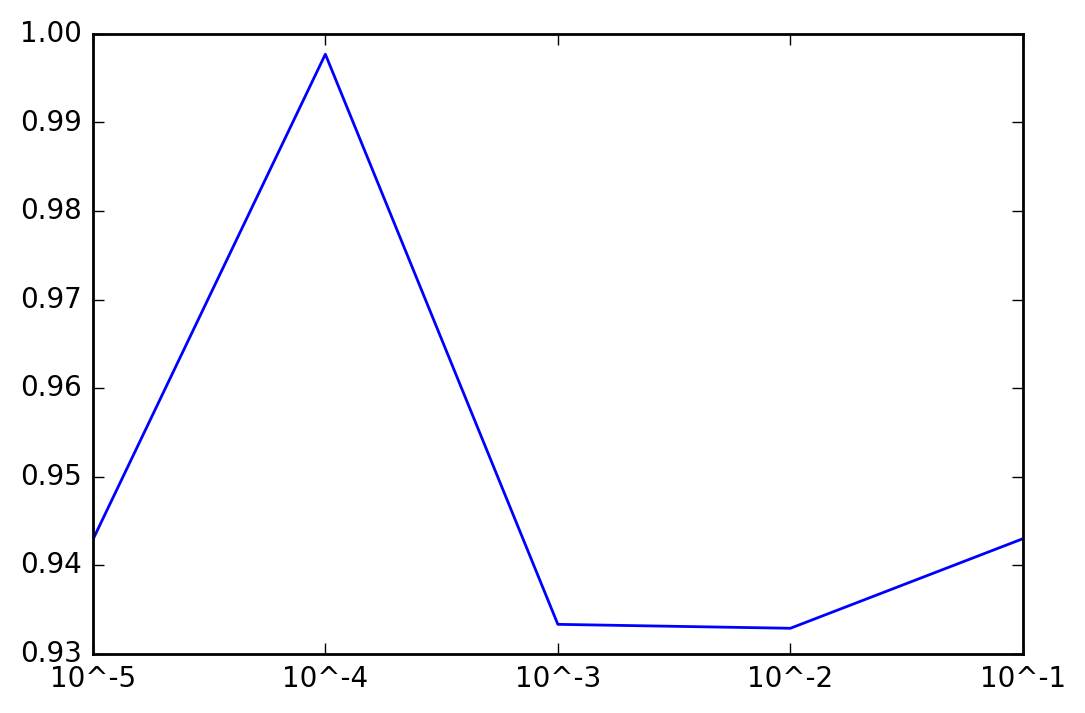

Best Regularization Term 0.01
Best Validation RMSE Achieved 0.932891060097


In [13]:
x = [1,2,3,4,5]
my_xticks = ["10^-5","10^-4","10^-3","10^-2","10^-1"]
plt.xticks(x, my_xticks)
plt.plot(x,evaluations)
plt.show()
print "Best Regularization Term", best_regularization_term
print "Best Validation RMSE Achieved", best_RMSE

In [14]:
factorization_recommender = gl.recommender.factorization_recommender.create(sf_train, \
                                                                            user_id='user_id', \
                                                                            item_id='item_id', \
                                                                            target='rating', \
                                                                            regularization=best_regularization_term, \
                                                                            random_seed=42)

print "Test RMSE on best model", factorization_recommender.evaluate_rmse(sf_test,'rating')['rmse_overall']

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46254 observations with 568 users and 1584 items.

Data prepared in: 0.173275s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46254 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.159173          | 0.742649                                 |

| 1       | 0.0795867         | 0.807664                                 |

| 2       | 0.0397934         | 0.911116                                 |

| 3       | 0.0198967         | 1.02927                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.159173          | 0.742649                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 142us        | 1.27553           | 1.1294                |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 394.277ms    | 0.996897          | 0.98089               | 0.159173    |

| 2       | 797.552ms    | 0.862297          | 0.928599              | 0.159173    |

| 3       | 1.20s        | 0.844832          | 0.919147              | 0.159173    |

| 4       | 1.60s        | 0.83679           | 0.914762              | 0.159173    |

| 5       | 1.81s        | 0.832098          | 0.912194              | 0.159173    |

| 6       | 2.20s        | 0.828687          | 0.910323              | 0.159173    |

| 10      | 3.80s        | 0.822475          | 0.906904              | 0.159173    |

| 11      | 4.09s        | 0.821521          | 0.906378              | 0.159173    |

| 15      | 5.60s        | 0.818831          | 0.904893              | 0.159173    |

| 20      | 7.12s        | 0.816937          | 0.903845              | 0.159173    |

| 25      | 8.60s        | 0.815613          | 0.903113              | 0.159173    |

| 30      | 10.39s       | 0.81465           | 0.90258               | 0.159173    |

| 35      | 12.30s       | 0.813869          | 0.902147              | 0.159173    |

| 40      | 14.30s       | 0.813429          | 0.901903              | 0.159173    |

| 45      | 16.01s       | 0.81296           | 0.901643              | 0.159173    |

| 50      | 18.10s       | 0.812517          | 0.901397              | 0.159173    |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.807769

Final training RMSE: 0.89876

Test RMSE on best model 0.939222087415


## Item-Item Similarity Recommender

Item Similarity recommenders can use the "0/1" ratings model to train the algorithms (where 0 means
the item was not rated by the user and 1 means it was). No other information is used. For these types of
recommenders, a ranked list of items **recommended** for each user is made available as the output, based
on "similar" items. Instead of RMSE, a Precision/Recall metric can be used to evaluate the accuracy of the
model.

*graphlab.recommender.item_similarity_recommender.create*
>Create a recommender that uses item-item similarities based on users in common.

In [15]:
item_similarity_recommender = gl.recommender.item_similarity_recommender.create(sf_train, \
                                                                                user_id='user_id', \
                                                                                item_id='item_id', \
                                                                                target='rating')
                                                                                
print "Test RMSE on model", item_similarity_recommender.evaluate_rmse(sf_test,'rating')['rmse_overall']

Recsys training: model = item_similarity

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 46254 observations with 568 users and 1584 items.

Data prepared in: 0.114913s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 4.164ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 7.304ms                             | 0                | 2               |

| 266.766ms                           | 100              | 1584            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.280779s

Test RMSE on model 3.67010731559


# Top K Recommendations

Based on scores assigned to User-Item pairs, each recommender algorithm makes available functions that
will provide a sorted list of top-K items most highly recommended for each user (from among those items
not already rated by the user).

Here we can calculate the top k recommendations for each user. We calculate the top 5 for each of the different models and print the Collaborative Filtering model to give you an idea of what these recommendations look like.

In [16]:
k=5
popularity_top_k = popularity_recommender.recommend(k=k)
factorization_top_k = factorization_recommender.recommend(k=k)
item_similarity_top_k = item_similarity_recommender.recommend(k=k)
print factorization_top_k


+---------+---------+---------------+------+
| user_id | item_id |     score     | rank |
+---------+---------+---------------+------+
|   186   |   1449  | 4.76939079656 |  1   |
|   186   |   320   | 4.60472509755 |  2   |
|   186   |   483   | 4.60426518811 |  3   |
|   186   |   408   | 4.57059178247 |  4   |
|   186   |   318   | 4.55248341455 |  5   |
|   253   |   1449  | 5.05754742517 |  1   |
|   253   |   320   | 4.89288172616 |  2   |
|   253   |   483   | 4.89242181672 |  3   |
|   253   |   408   | 4.85874841108 |  4   |
|   253   |   169   | 4.79626366986 |  5   |
+---------+---------+---------------+------+
[2840 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


## Evaluation: Precision/Recall comparison between the three models

For the top-K recommendations based evaluation, such as in Item Similarity recommenders, we can
evaluate using a Confusion Matrix or Precision/Recall values. Specifically, 
1. Precision: out of K top recommendations, how many of the true best K movies were recommended.
2. Recall: out of the K top recommendations, how many were recommended.  (the statement is questionable)

*graphlab.recommender.util.compare_models*
>Compare the prediction or recommendation performance of recommender models on a common test dataset. Models that are trained to predict ratings are compared separately from models that are trained without target ratings. The ratings prediction models are compared on root-mean-squared error, and the rest are compared on precision-recall.

In [17]:
models = [popularity_recommender,factorization_recommender,item_similarity_recommender]
model_names = ['popularity_recommender','factorization_recommender','item_similarity_recommender']
precision_recall = gl.recommender.util.compare_models(sf_test,models,metric='precision_recall',model_names=model_names)

PROGRESS: Evaluate model popularity_recommender

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision  |    mean_recall    |
+--------+------------------+-------------------+
|   1    | 0.00352112676056 | 4.81705114993e-05 |
|   2    | 0.00264084507042 | 5.64360672752e-05 |
|   3    | 0.00234741784038 | 0.000129792874787 |
|   4    | 0.00220070422535 | 0.000154245143958 |
|   5    | 0.00176056338028 | 0.000154245143958 |
|   6    | 0.00176056338028 | 0.000176530756366 |
|   7    | 0.00201207243461 |  0.00021801900208 |
|   8    | 0.00176056338028 |  0.00021801900208 |
|   9    | 0.00176056338028 | 0.000258962336505 |
|   10   | 0.00193661971831 | 0.000280770687514 |
+--------+------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model factorization_recommender

Precision and recall summary statistics by cutoff
+--------+------------------+-------------------+
| cutoff |  mean_precision